<a href="https://colab.research.google.com/github/regiiis/pv_error_classification/blob/main/pv_error_classifcation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DLV Group Project - **Semantic Segmentation**

## Set up

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [54]:
# General imports
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import savetxt
from numpy import genfromtxt
import os, datetime
import sys
import math
import random

# Import graph plotting lib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Imoprt tensorflow and set to eager execution
import tensorflow as tf
tf.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)

# Shortcuts to keras
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.utils import array_to_img
from IPython.display import Image

# Performance tools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

from PIL import Image
from PIL import Image as im
from skimage.transform import resize

In [3]:
# Import drive and allow access
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Unzip data

!unzip "/content/drive/My Drive/Colab Notebooks/data/2020-02-14_InfraredSolarModules.zip"

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: InfraredSolarModules/images/2121.jpg  
  inflating: InfraredSolarModules/images/11778.jpg  
  inflating: InfraredSolarModules/images/5896.jpg  
  inflating: InfraredSolarModules/images/4550.jpg  
  inflating: InfraredSolarModules/images/19324.jpg  
  inflating: InfraredSolarModules/images/16017.jpg  
  inflating: InfraredSolarModules/images/10472.jpg  
  inflating: InfraredSolarModules/images/2135.jpg  
  inflating: InfraredSolarModules/images/4.jpg  
  inflating: InfraredSolarModules/images/5882.jpg  
  inflating: InfraredSolarModules/images/19330.jpg  
  inflating: InfraredSolarModules/images/4544.jpg  
  inflating: InfraredSolarModules/images/16003.jpg  
  inflating: InfraredSolarModules/images/12265.jpg  
  inflating: InfraredSolarModules/images/9060.jpg  
  inflating: InfraredSolarModules/images/14614.jpg  
  inflating: InfraredSolarModules/images/6353.jpg  
  inflating: InfraredSolarModules/images/970

In [5]:
# Load data into df

df = pd.read_json("/content/InfraredSolarModules/module_metadata.json",orient="index")
df['image_name'] = df['image_filepath'].str[7:]
df = df.sort_index()
df

,image_filepath,anomaly_class,image_name
0,images/0.jpg,Offline-Module,0.jpg
1,images/1.jpg,Offline-Module,1.jpg
2,images/2.jpg,Offline-Module,2.jpg
3,images/3.jpg,Offline-Module,3.jpg
4,images/4.jpg,Offline-Module,4.jpg
...,...,...,...
19995,images/19995.jpg,No-Anomaly,19995.jpg
19996,images/19996.jpg,No-Anomaly,19996.jpg
19997,images/19997.jpg,No-Anomaly,19997.jpg
19998,images/19998.jpg,No-Anomaly,19998.jpg


## Explore Data

In [9]:
# Display all categories

categories = df["anomaly_class"].unique()
list(categories)

['Offline-Module',
 'Diode-Multi',
 'Diode',
 'Shadowing',
 'Cell-Multi',
 'Cell',
 'Hot-Spot',
 'Cracking',
 'Hot-Spot-Multi',
 'Soiling',
 'Vegetation',
 'No-Anomaly']

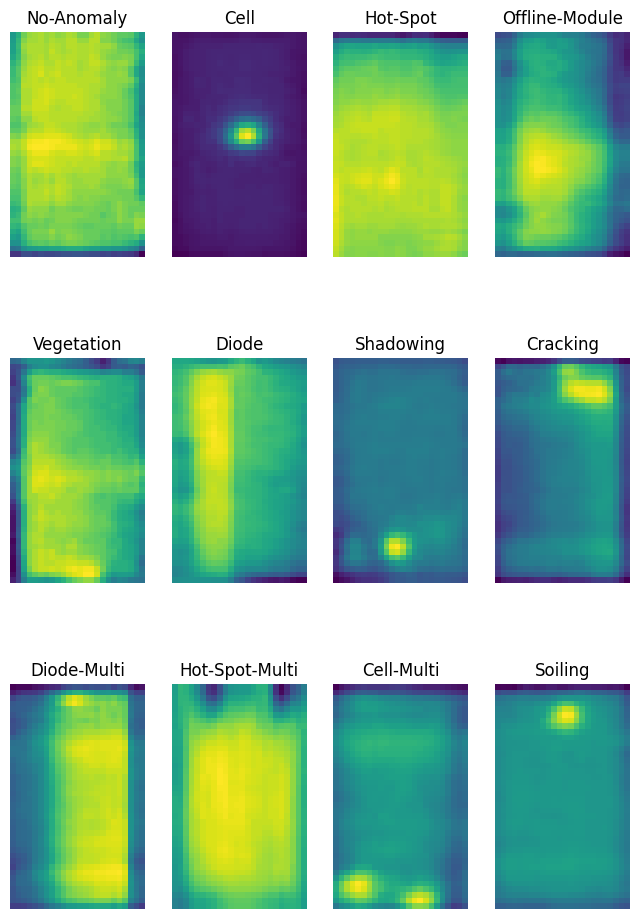

In [119]:
# Select and display a iamge for each category

df.groupby('anomaly_class').head(1)
img1 = mpimg.imread('/content/InfraredSolarModules/images/13357.jpg') #No-Anomaly
img2 = mpimg.imread('/content/InfraredSolarModules/images/5988.jpg')  #Cell
img3 = mpimg.imread('/content/InfraredSolarModules/images/6796.jpg')  #Hot-Spot
img4 = mpimg.imread('/content/InfraredSolarModules/images/270.jpg')  #Offline-Module
img5 = mpimg.imread('/content/InfraredSolarModules/images/9528.jpg') #Vegetation
img6 = mpimg.imread('/content/InfraredSolarModules/images/2143.jpg')  #Diode
img7 = mpimg.imread('/content/InfraredSolarModules/images/3519.jpg')  #Shadowing
img8 = mpimg.imread('/content/InfraredSolarModules/images/7188.jpg')  #Cracking
img9 = mpimg.imread('/content/InfraredSolarModules/images/876.jpg') #Diode-Multi
img10 = mpimg.imread('/content/InfraredSolarModules/images/8019.jpg')  #Hot-Spot-Multi
img11 = mpimg.imread('/content/InfraredSolarModules/images/4592.jpg')  #Cell-Multi
img12 = mpimg.imread('/content/InfraredSolarModules/images/8291.jpg')  #Soiling

#create list of image name
list_img = []
for i in range(12):
  list_img.append(f"img{i+1}")

# Create list of category names
list_categories = ['No-Anomaly','Cell','Hot-Spot','Offline-Module','Vegetation','Diode','Shadowing',
            'Cracking','Diode-Multi','Hot-Spot-Multi','Cell-Multi','Soiling']

# Plot images
fig = plt.figure(figsize=(8, 12))
columns = 4
rows = 3
for i,n in zip(range(1, columns*rows +1),list_categories):
    img = f"img{i}"
    fig.add_subplot(rows, columns, i)
    plt.imshow(globals()[img])
    plt.title(n)
    plt.axis('off')
plt.show()



In [118]:
# Summary Statistics

df["anomaly_class"].describe()

count          20000
unique            12
top       No-Anomaly
freq           10000
Name: anomaly_class, dtype: object


Text(0.5, 1.0, 'Category Distribution')

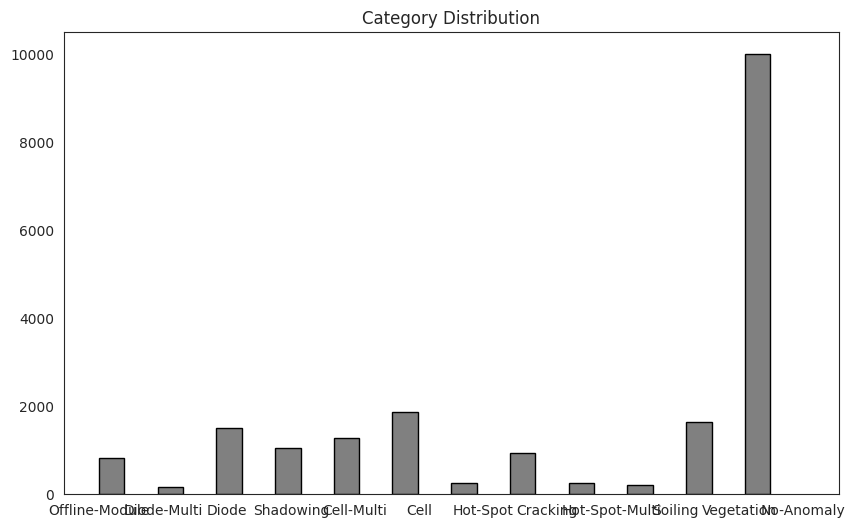

In [138]:
from IPython.core.pylabtools import figsize
import seaborn as sns
sns.set_style("white")

figsize(10, 6)
plt.hist(df["anomaly_class"], color='grey', edgecolor='black', bins=12, width=0.4, rwidth=1)
plt.title('Category Distribution')